### ПРОЕКТ Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.


Описание данных:
    <br>Каждая запись в логе — это действие пользователя, или событие.
* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [4]:
#загрузим нужные библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats as st
import math as mth
from statsmodels.stats.proportion import proportions_ztest

#### Шаг 1. Откроем файл с данными и изучим общую информацию

In [5]:
#загрузим данные

log_exp = pd.read_csv('logs_exp.csv',sep='\t')
log_exp.sample(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
193239,OffersScreenAppear,2783380201734445914,1565093832,246
95217,CartScreenAppear,4623191541214045580,1564842280,247
12757,MainScreenAppear,6326495816973010604,1564652779,247
70205,OffersScreenAppear,7586870289028771156,1564771791,247
242009,CartScreenAppear,5996739817823449506,1565205373,248


In [6]:
log_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [7]:
# посмотрим какие есть события
log_exp['EventName'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [8]:
# проверим на дубликаты
log_exp.duplicated().sum()

413

In [9]:
#избавимся от 0,17% дублей
log_exp = log_exp[log_exp.duplicated() == False].reset_index(drop=True)

Вывод: похоже в данных нет пропусков, события представлены некоторой воронкой, а дата представлена в формате unix. Было немного дублей, но от них избавились

#### Шаг 2. Подготовим данные


In [10]:
#переименуем столбцы

log_exp.columns = ['event','device_id','date_time','group']

In [11]:
#пропусков ранее мы не выявили, а вот столбец с датой надо преобразовать
log_exp['date_time'] = pd.to_datetime(log_exp['date_time'],unit='s')
#добавим отдельно столбец только с датой
log_exp['date'] = log_exp['date_time'].dt.date

#### Шаг 3. Изучим и проверим данные


In [12]:
print('Событий в логе:',log_exp.shape[0])
print('Уникальных пользователей:',log_exp.device_id.unique().shape[0])
print('Среднее число событий на пользователя:',log_exp.shape[0]/log_exp.device_id.unique().shape[0])

Событий в логе: 243713
Уникальных пользователей: 7551
Среднее число событий на пользователя: 32.27559263673685


In [13]:
# найдём максимальную и минимальные даты

print('Самая ранняя запись в логе:',log_exp.agg({'date':'min'})[0])
print('Самая поздняя запись в логе:',log_exp.agg({'date':'max'})[0])

Самая ранняя запись в логе: 2019-07-25
Самая поздняя запись в логе: 2019-08-07


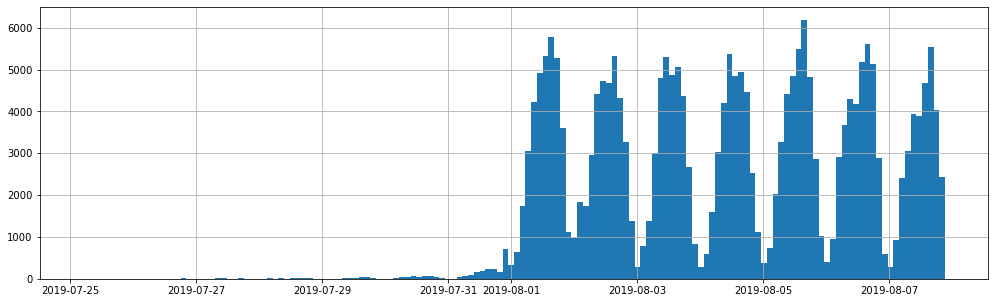

In [14]:
#посмотрим, как распределены данные по датам
log_exp['date_time'].hist(bins=150,figsize = (17,5))
plt.show()

Похоже, что на самом деле данные у нас только за период с 1 августа по 7 августа

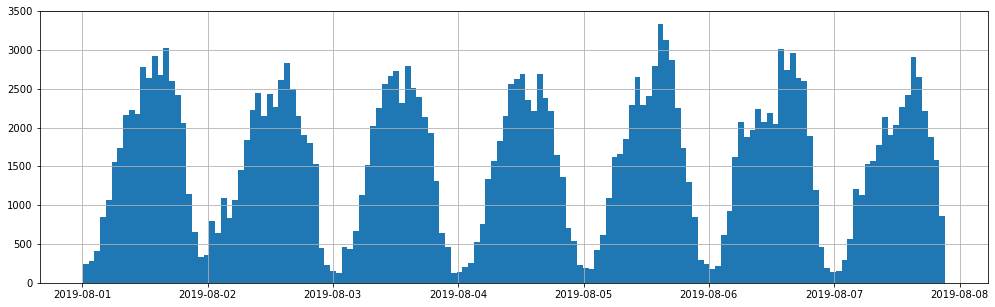

In [15]:
#откинем данные до 1 августа
log_exp = log_exp[log_exp['date']>=pd.to_datetime('2019-08-01')].reset_index(drop=True)
log_exp['date_time'].hist(bins=150,figsize = (17,5))
plt.show()

In [16]:
print('Итого событий в логе:',log_exp.shape[0])
print('Итого уникальных пользователей:',log_exp.device_id.unique().shape[0])

Итого событий в логе: 240887
Итого уникальных пользователей: 7534


Откинув данные до 1 августа мы потеряли около 3 тыс. событий ~1,2% и 17 потльзователнй ~0,2%.

In [17]:
# проверим количество пользователей в каждой группе
log_exp.groupby('group').agg({'device_id':'nunique'})

,device_id
group,
246,2484
247,2513
248,2537


#### Шаг 4. Изучим воронку событий

In [18]:
#Посмотрим, какие события есть в логах, как часто они встречаются.
log_exp['event'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event, dtype: int64

In [19]:
#Посчитаем, сколько пользователей совершали каждое из событий. 
#Посчитаем долю пользователей, которые хоть раз совершали событие.

event_ratio = log_exp.groupby('event').agg({'device_id':'nunique'}).sort_values(by='device_id',ascending=False)
event_ratio['ratio'] = event_ratio['device_id']/event_ratio['device_id'][0]

In [20]:
#По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки

funnel = event_ratio[['device_id']][0:4]
funnel['churn'] = funnel['device_id'].pct_change()
funnel

,device_id,churn
event,,
MainScreenAppear,7419,NaN
OffersScreenAppear,4593,-0.380914
CartScreenAppear,3734,-0.187024
PaymentScreenSuccessful,3539,-0.052223



Больше всего пользователей теряется на шаге "OffersScreenAppear", -40% от  пользователей увидевших главныый экран.

In [21]:
#Какая доля пользователей доходит от первого события до оплаты?

funnel['device_id'][3]/funnel['device_id'][0]

0.47701846610055265

До оплаты доходит 47% пользователей, увидевших начальный экран. Достаточно высокая конверсия ля ритейла.

#### Шаг 5. Изучим результаты эксперимента


In [22]:
# Сколько пользователей в каждой экспериментальной группе?
group_size = log_exp.groupby('group').agg({'device_id':'nunique'})
group_size

,device_id
group,
246,2484
247,2513
248,2537


In [23]:
print('количественные различия м\у группами 246 и 247:',(group_size['device_id'][247]/group_size['device_id'][246])*100-100,'%')

количественные различия м\у группами 246 и 247: 1.1674718196457405 %


In [24]:
#Проверим, находят ли статистические критерии разницу между выборками 246 и 247.
# проверим гипотезу, о том что конверсия в покупателей у группы 246 и 247 одинаковые
group_246 = log_exp.query('group == 246')
group_246_grouped = group_246.groupby('event').agg({'device_id':'nunique'})
trials_246 = group_size.loc[246][0]
successes_246 = group_246_grouped.loc['PaymentScreenSuccessful'][0]

group_247 = log_exp.query('group == 247')
group_247_grouped = group_247.groupby('event').agg({'device_id':'nunique'})
trials_247 = group_size.loc[247][0]
successes_247 = group_247_grouped.loc['PaymentScreenSuccessful'][0]


#для проверки воспользуемся Z статистикой
alpha = .05

#конверсии в группах
conv1 = successes_246/trials_246
conv2 = successes_247/trials_247

#комбинированная конверсия:
conv_combine = (successes_246+successes_247)/(trials_246+trials_247)

#разница конверсий
conv_diff = conv1-conv2

z_value = conv_diff/mth.sqrt(conv_combine * (1 - conv_combine) * (1/trials_246 + 1/trials_247))
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p_value:',p_value)

p_value: 0.11456679313141849


<b>С учётом того, что p_value больше уровня стат значимости нет оснований пологать, что конверсии групп 246 и 247 различны, таким образом, для сравнения конверсии с экспериментальной группой можно взять любую из контрольных</b>


In [25]:
# Проделаем то же самое для всех других событий .

# подготовим функцию, которая на основании Z статистики определит есть ли стат. значимая разница между конверсиями групп
def stat_check(group1,group2,data):
    group_A = data.query('group == @group1')
    group_A_grouped = group_A.groupby('event').agg({'device_id':'nunique'})
    trials_A = data.groupby('group').agg({'device_id':'nunique'}).loc[group1][0]
    
    group_B = data.query('group == @group2')
    group_B_grouped = group_B.groupby('event').agg({'device_id':'nunique'})
    trials_B = data.groupby('group').agg({'device_id':'nunique'}).loc[group2][0]
    
    nobs = np.array([trials_A,trials_B])
    events = data['event'].unique()
    
    for event in events:
        successes_A = group_A_grouped.loc[event][0]
        successes_B = group_B_grouped.loc[event][0]
        successes = np.array([successes_A,successes_B])
        stat, pval = proportions_ztest(successes,nobs)
        print('p-value = {:.3%}, для события:{}'.format(pval,event))

In [26]:
#определим уровень статистической значимости с учётом проведения 20 попарных тестов.
# Скорректируем a=.05 в соответствии с методом Шидака
m = 20
alpha = .05
alpha = 1-(1-alpha)**(1/m)
print('скорректированное значение alpha(%):',alpha*100)

скорректированное значение alpha(%): 0.25613787765302876


In [27]:
stat_check(246,247,log_exp)

p-value = 93.770%, для события:Tutorial
p-value = 75.706%, для события:MainScreenAppear
p-value = 24.810%, для события:OffersScreenAppear
p-value = 22.883%, для события:CartScreenAppear
p-value = 11.457%, для события:PaymentScreenSuccessful


Похоже, что p_value, расчитанное для каждого шага воронки, подтверждает схожесть конверсий между контрольными группами. Таким образом, разбиение на группы работает корректно.

In [28]:
# оценим схожесть конверсий контрольной группы 246 и эксперементальной группы.
stat_check(246,248,log_exp)

p-value = 82.643%, для события:Tutorial
p-value = 29.497%, для события:MainScreenAppear
p-value = 20.836%, для события:OffersScreenAppear
p-value = 7.843%, для события:CartScreenAppear
p-value = 21.226%, для события:PaymentScreenSuccessful


In [29]:
# оценим схожесть конверсий контрольной группы 247 и эксперементальной группы.
stat_check(247,248,log_exp)

p-value = 76.532%, для события:Tutorial
p-value = 45.871%, для события:MainScreenAppear
p-value = 91.978%, для события:OffersScreenAppear
p-value = 57.862%, для события:CartScreenAppear
p-value = 73.734%, для события:PaymentScreenSuccessful


In [30]:
# оценим схожесть конверсий объединенных контрольных групп и эксперементальной группы.
group_A = log_exp.query('group == 246 |group == 247')
group_A_grouped = group_A.groupby('event').agg({'device_id':'nunique'})
trials = log_exp.groupby('group').agg({'device_id':'nunique'})
trials_A = trials.loc[246][0]+trials.loc[247][0]    

group_B = log_exp.query('group == 248')
group_B_grouped = group_B.groupby('event').agg({'device_id':'nunique'})
trials_B = log_exp.groupby('group').agg({'device_id':'nunique'}).loc[248][0]
    
nobs = np.array([trials_A,trials_B])
events = log_exp['event'].unique()
    
for event in events:
    successes_A = group_A_grouped.loc[event][0]
    successes_B = group_B_grouped.loc[event][0]
    successes = np.array([successes_A,successes_B])
    stat, pval = proportions_ztest(successes,nobs)
    print('p-value = {:.3%}, для события:{}'.format(pval,event))

p-value = 76.486%, для события:Tutorial
p-value = 29.425%, для события:MainScreenAppear
p-value = 43.426%, для события:OffersScreenAppear
p-value = 18.176%, для события:CartScreenAppear
p-value = 60.043%, для события:PaymentScreenSuccessful


#### Общий вывод\итог работы:
1. Данные были очищенны от полных дублей - 413, что меньше 0,5% данных. Вероятная причина появления дублей - ошибки вследствии синхронизации данных из приложений с БД.
2. Лог данных был очищен от событий до 1 августа, так как до этого периода не наблюдается полноты и сопостовимости объёма данных. Таким образом, анализ был проведен на данных с 1 августа по 7 августа.
3. Исходя из анализа событий (event) можно прийти к выводу, что события в воронке не всегда являются последовательными, например, обучение просматривают менее 3% покупателей.
4. Наибольшее кол-во пользователей теряется при перехое с главного экрана на экран оффера (~40%). Возможно этот экран виден не всем пользователям, что не позволяет им двигаться по воронке дальше.
5. В ходе статистического исследования было установлено, что между конверсиями контрольных групп отсутствуют существенные различия.
6. Существенные розличия в конверсии также отсутствуют и среди тех, кому показывали новый шрифт, при этом вероятность схожести достаточно высока, что даже в случае увеличения уровня существенности до 10% или меньшей корректировки при проведении меньшего кол-ва попарных тестов не скажется на выводе о схожести контрольных и эксперементальных групп.

<b> Таким образом, можно успокоить менеджеров - новый шрифт скорее всего не отпугнёт пользователей и не отразится на снижении конверсии. </b>
